In [25]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the tables 
covid_df = pd.read_csv('../data/covid.csv', index_col=False)
precovid_df = pd.read_csv('../data/precovid.csv')
postcovid_df = pd.read_csv('../data/postcovid.csv')

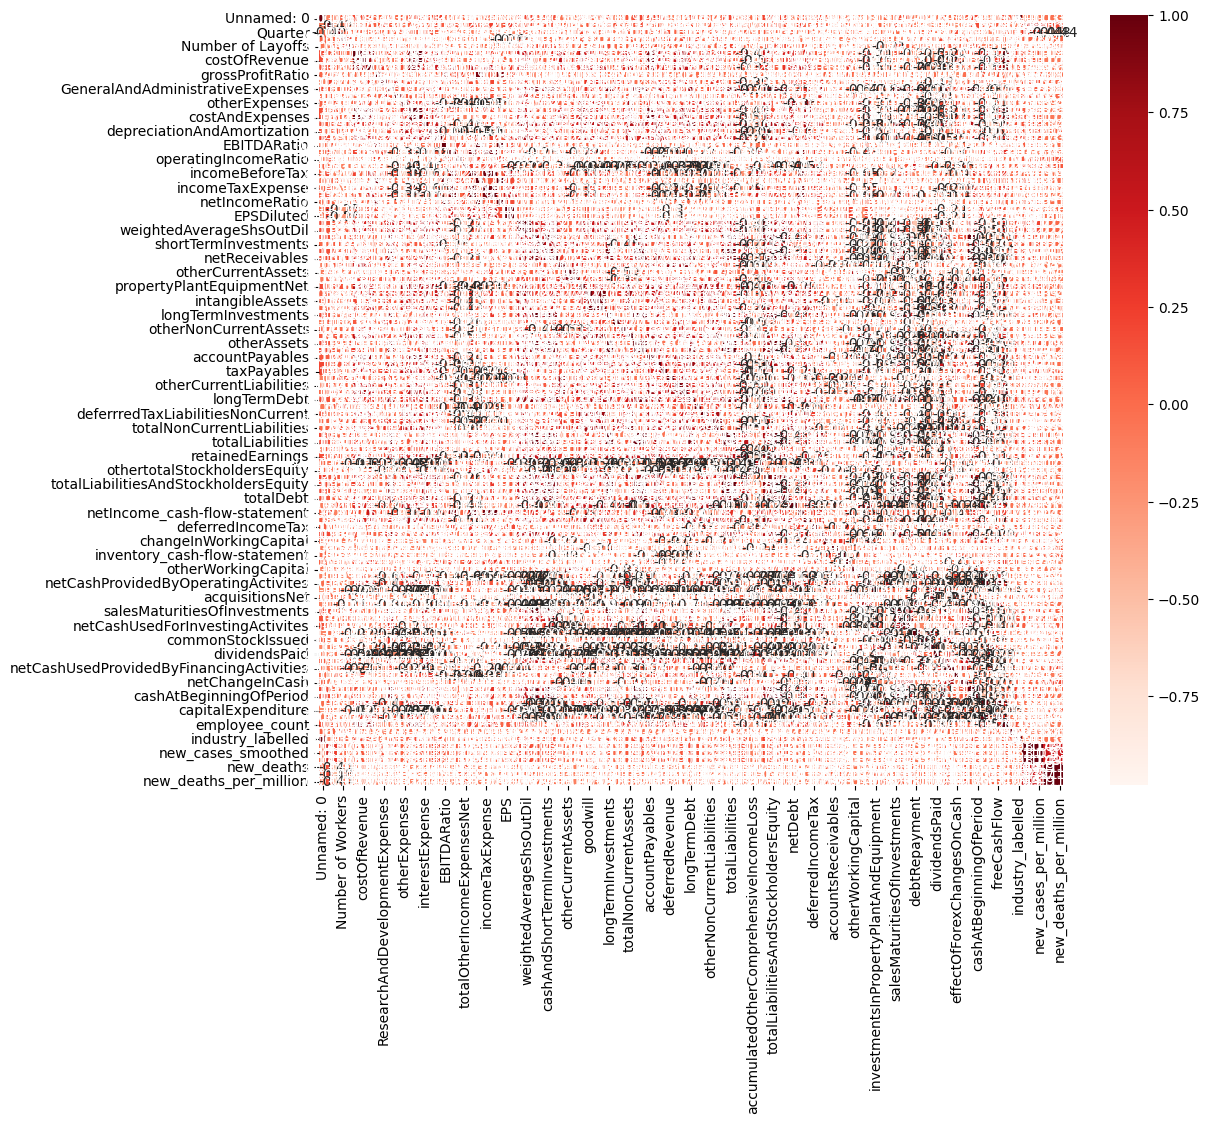

In [19]:
plt.figure(figsize=(12,10))
cor = covid_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
covid_df = covid_df.drop(columns={'Unnamed: 0'})
covid_df

,Year,Quarter,Number of Workers,Number of Layoffs,revenue,costOfRevenue,grossProfit,grossProfitRatio,ResearchAndDevelopmentExpenses,GeneralAndAdministrativeExpenses,...,freeCashFlow,employee_count,percent_layoff,industry_labelled,new_cases,new_cases_smoothed,new_cases_per_million,new_deaths,new_deaths_smoothed,new_deaths_per_million
0,2020,3,6775,2,3.173000e+09,5.610000e+09,-2.437000e+09,-0.768043,0.000000e+00,0.000000e+00,...,-3.181000e+09,118033.0,0.057399,2,50113.815217,50152.321380,148.138696,890.315217,899.428554,2.631826
1,2021,1,3920,3,4.008000e+09,6.164000e+09,-2.156000e+09,-0.537924,0.000000e+00,0.000000e+00,...,1.740000e+08,118033.0,0.033211,2,116989.855556,120848.299989,345.827267,2236.066667,2291.728556,6.609944
2,2020,2,94,1,2.501380e+09,1.404666e+09,1.096714e+09,0.438444,0.000000e+00,0.000000e+00,...,3.801700e+08,0.0,NaN,3,26741.428571,26039.981154,79.048879,1372.780220,1360.849286,4.058055
3,2021,3,26,1,1.434200e+10,4.390000e+09,9.952000e+09,0.693906,1.673000e+09,0.000000e+00,...,7.718000e+09,47000.0,0.000553,6,105140.771739,102092.024870,310.800826,1035.130435,983.925446,3.059891
4,2020,2,844,2,1.445100e+09,1.202300e+09,2.428000e+08,0.168016,0.000000e+00,1.233000e+08,...,4.178000e+08,7600.0,0.111053,8,26741.428571,26039.981154,79.048879,1372.780220,1360.849286,4.058055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2020,2,1125,1,5.238260e+08,3.955110e+08,1.283150e+08,0.244957,3.452200e+07,5.736100e+07,...,1.505260e+08,7100.0,0.158451,571,26741.428571,26039.981154,79.048879,1372.780220,1360.849286,4.058055
265,2020,2,737,1,2.091000e+09,2.274000e+09,-1.830000e+08,-0.087518,0.000000e+00,6.200000e+07,...,-3.930000e+08,22514.0,0.032735,573,26741.428571,26039.981154,79.048879,1372.780220,1360.849286,4.058055
266,2020,4,677,1,4.573800e+10,6.233200e+10,-1.659400e+10,-0.362806,0.000000e+00,2.736000e+09,...,3.760000e+08,0.0,NaN,574,134353.271739,129908.336978,397.154261,1541.793478,1481.576043,4.557598
267,2020,2,461,1,4.906000e+08,3.145000e+08,1.761000e+08,0.358948,0.000000e+00,2.791000e+08,...,1.619000e+08,5100.0,0.090392,576,26741.428571,26039.981154,79.048879,1372.780220,1360.849286,4.058055


In [28]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import spearmanr, pearsonr

skb = SelectKBest(score_func=spearmanr)
input_df = covid_df.drop(columns={'Number of Workers','percent_layoff'})
X = input_df
y = covid_df['Number of Workers']
skb.fit(X, y)

SelectKBest(score_func=<function spearmanr at 0x14ec64ee0>)

In [29]:
skb.scores_

array([[ 1.        , -0.40012133, -0.03378738, ...,  0.03751929,
         0.03751929, -0.02214098],
       [-0.40012133,  1.        , -0.03382486, ..., -0.34698903,
        -0.34698903, -0.08593104],
       [-0.03378738, -0.03382486,  1.        , ..., -0.02241587,
        -0.02241587,  0.46010255],
       ...,
       [ 0.03751929, -0.34698903, -0.02241587, ...,  1.        ,
         1.        ,  0.06734848],
       [ 0.03751929, -0.34698903, -0.02241587, ...,  1.        ,
         1.        ,  0.06734848],
       [-0.02214098, -0.08593104,  0.46010255, ...,  0.06734848,
         0.06734848,  1.        ]])